In [6]:
import numpy as np
import matplotlib.pyplot as plt


In [7]:

alpha = 110
length = 50 # length of the plate, 50 mm
time = 2 # total time, 10 s
nodes = 10 # number of nodes - 1

dx = length / nodes # distance between nodes
dy = length / nodes # distance between nodes
# time step, must be less or equal to than min of dx^2 / (4 * alpha) and dy^2 / (4 * alpha)
dt = np.min([0.25 * dx**2 / alpha, 0.25 * dy**2 / alpha]) 

x_train = np.linspace(0, length, nodes)
y_train = np.linspace(0, length, nodes)
t_train = np.linspace(0, time, int(time / dt))

u = np.zeros((nodes, nodes)) + 20 # middle of the plate is 20 degrees
# for i in range(len(u[0, :])): # top ranges from 20 to 78 degrees linearly
#     u[0, i] = 20 + 3*i
u[0, :] = 100 # bottom side of the plate is 100 degrees
# u[-1, :] = 100 # top side of the plate is 100 degrees
# u[:, 0] = 100 # left side of the plate is 100 degrees
# u[:, -1] = 100 # right side of the plate is 100 degrees

# fig, axis = plt.subplots()
# pcm = axis.pcolormesh(u, cmap='gist_rainbow', vmin=0, vmax=100)
# plt.colorbar(pcm, ax=axis)

heat_data = np.zeros((int(time / dt), nodes, nodes))

for counter in range(heat_data.shape[0]):
    w = u.copy()

    for i in range(1, nodes - 1):
        for j in range(1, nodes - 1):
            dd_ux = (w[i - 1, j] - 2 * w[i, j] + w[i + 1, j]) / dx**2
            dd_uy = (w[i, j - 1] - 2 * w[i, j] + w[i, j + 1]) / dy**2

            u[i, j] = dt * alpha * (dd_ux + dd_uy) + w[i, j]

    heat_data[counter, :, :] = u.copy()

    # pcm.set_array(u)
    # plt.pause(0.01)
    # axis.set_title(f't: {counter:.3f} s')
    print(f't: {counter * dt:.3f} s, Ave temp: {np.mean(u):.2f} C')

# plt.show()
print(heat_data.shape)

t: 0.000 s, Ave temp: 29.60 C
t: 0.057 s, Ave temp: 30.70 C
t: 0.114 s, Ave temp: 31.57 C
t: 0.170 s, Ave temp: 32.31 C
t: 0.227 s, Ave temp: 32.94 C
t: 0.284 s, Ave temp: 33.50 C
t: 0.341 s, Ave temp: 34.00 C
t: 0.398 s, Ave temp: 34.45 C
t: 0.455 s, Ave temp: 34.86 C
t: 0.511 s, Ave temp: 35.24 C
t: 0.568 s, Ave temp: 35.59 C
t: 0.625 s, Ave temp: 35.92 C
t: 0.682 s, Ave temp: 36.22 C
t: 0.739 s, Ave temp: 36.50 C
t: 0.795 s, Ave temp: 36.77 C
t: 0.852 s, Ave temp: 37.01 C
t: 0.909 s, Ave temp: 37.24 C
t: 0.966 s, Ave temp: 37.46 C
t: 1.023 s, Ave temp: 37.66 C
t: 1.080 s, Ave temp: 37.85 C
t: 1.136 s, Ave temp: 38.03 C
t: 1.193 s, Ave temp: 38.20 C
t: 1.250 s, Ave temp: 38.36 C
t: 1.307 s, Ave temp: 38.50 C
t: 1.364 s, Ave temp: 38.64 C
t: 1.420 s, Ave temp: 38.77 C
t: 1.477 s, Ave temp: 38.89 C
t: 1.534 s, Ave temp: 39.01 C
t: 1.591 s, Ave temp: 39.12 C
t: 1.648 s, Ave temp: 39.22 C
t: 1.705 s, Ave temp: 39.31 C
t: 1.761 s, Ave temp: 39.40 C
t: 1.818 s, Ave temp: 39.49 C
t: 1.875 s

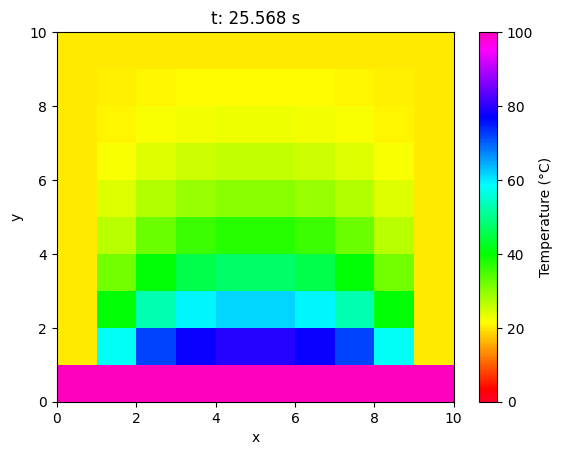

In [8]:
fig, axis = plt.subplots()
pcm = axis.pcolormesh(heat_data[25, :, :], cmap='gist_rainbow', vmin=0, vmax=100)
cbar = plt.colorbar(pcm, ax=axis)
cbar.set_label('Temperature (°C)')
axis.set_title(f't: {450*dt:.3f} s')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [9]:
heat_data.shape

(35, 10, 10)

In [10]:
import os
import sys

parent_dir = os.path.abspath('..')
sys.path.append(parent_dir)

In [11]:
from deep_learning import deep_network_core as core, utils
import torch
import torch.nn as nn
from torch.autograd import grad as autograd

In [12]:
# torch.manual_seed(1234)
# np.random.seed(1234)

Tr, Xr, Yr = np.meshgrid(t_train, x_train, y_train)

inpt = np.column_stack((Tr.ravel(), Xr.ravel(), Yr.ravel()))
oupt = heat_data.ravel()

In [13]:
class MSE_Loss(core.LOSS):
    def __init__(self):
        self.loss = nn.MSELoss()
        
    def __call__(self, target, result, model):
        return self.loss(target, result)

In [14]:
network_pinn = core.PINN(3, 1, 32, 2, [(1, MSE_Loss())])

In [15]:
print("Training PINN")
network_pinn.fit(inpt, oupt, lr=1e-2, epochs=10000)

Training PINN
Epoch 1/10000 loss: 2e+03
Epoch 1000/10000 loss: 6.3e+02
Epoch 2000/10000 loss: 6.3e+02
Epoch 3000/10000 loss: 6.2e+02
Epoch 4000/10000 loss: 6.1e+02
Epoch 5000/10000 loss: 5.8e+02
Epoch 6000/10000 loss: 5.7e+02
Epoch 7000/10000 loss: 5.5e+02
Epoch 8000/10000 loss: 5.3e+02
Epoch 9000/10000 loss: 5.2e+02
Epoch 10000/10000 loss: 5.1e+02


[2047.461181640625,
 1898.52880859375,
 1763.0872802734375,
 1600.7703857421875,
 1386.0264892578125,
 1133.5628662109375,
 901.9054565429688,
 817.5305786132812,
 1002.4578857421875,
 1097.7255859375,
 1001.0009765625,
 876.1455078125,
 814.7144775390625,
 818.8945922851562,
 854.3981323242188,
 890.831298828125,
 912.5322265625,
 914.9292602539062,
 899.8754272460938,
 872.83642578125,
 841.8660888671875,
 816.7373657226562,
 806.138916015625,
 812.8341674804688,
 830.1090698242188,
 843.835693359375,
 843.01708984375,
 828.8406982421875,
 811.4495849609375,
 800.4514770507812,
 798.6600952148438,
 803.3563842773438,
 809.6712646484375,
 813.513427734375,
 812.8981323242188,
 808.1287231445312,
 801.2473754882812,
 795.01806640625,
 791.7890625,
 792.2164916992188,
 794.8455200195312,
 796.8924560546875,
 796.1666870117188,
 792.7412719726562,
 788.5364379882812,
 785.672119140625,
 784.9307861328125,
 785.606689453125,
 786.3302612304688,
 786.0162353515625,
 784.367919921875,
 781.